# Clustering 3K PBMCs with Variational Autoencoders

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import os

from utils import plot_results_pca, plot_results_umap
from VAE import *

Using TensorFlow backend.


## Import dataset

os.makedirs('../data', exist_ok=True)
!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz -O ../data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz
!cd ../data; tar -xzf pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz

## Data preprocessing

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '../data/pbmc10k.h5ad'

scanpy==1.4.3 anndata==0.6.20 umap==0.3.9 numpy==1.16.4 scipy==1.2.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
sc.settings.set_figure_params(dpi=80)

In [5]:
adata = sc.read_10x_mtx(
            '../data/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
            var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
            cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/..-data-filtered_feature_bc_matrix-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

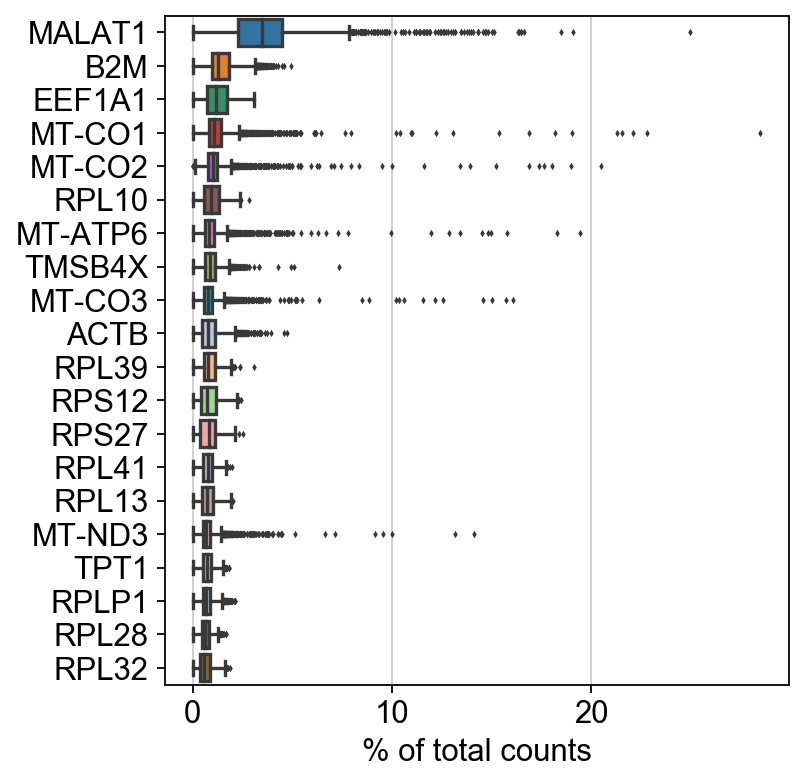

Trying to set attribute `.obs` of view, making a copy.


filtered out 9 cells that have less than 200 genes expressed
filtered out 15484 genes that are detected in less than 3 cells


In [7]:
# Show those genes that yield the highest fraction of counts in each single cells, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20)

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'feature_types' as categorical


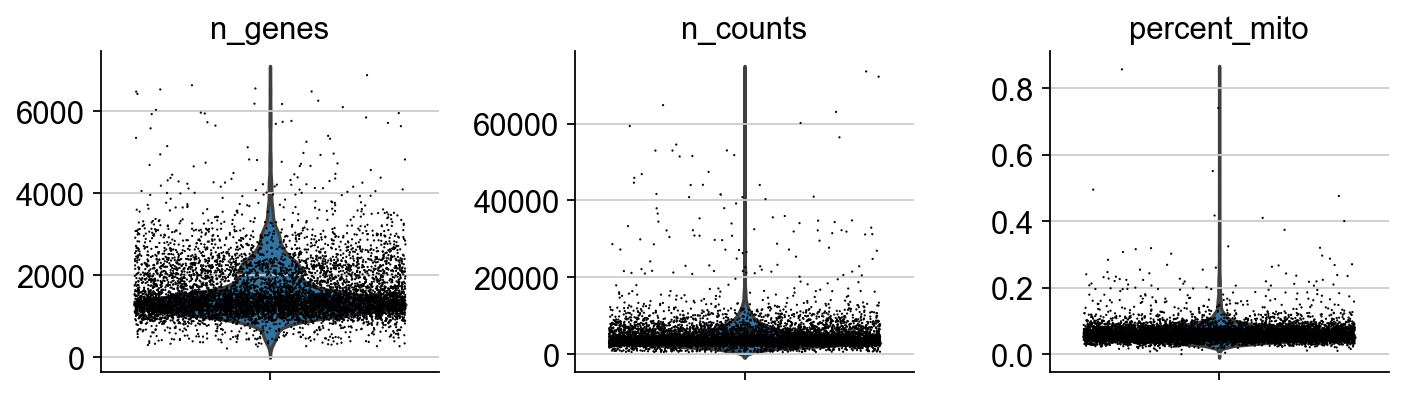

In [9]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

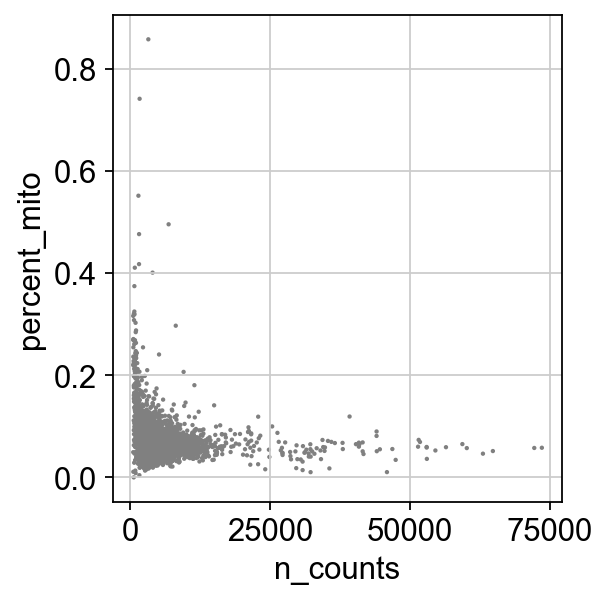

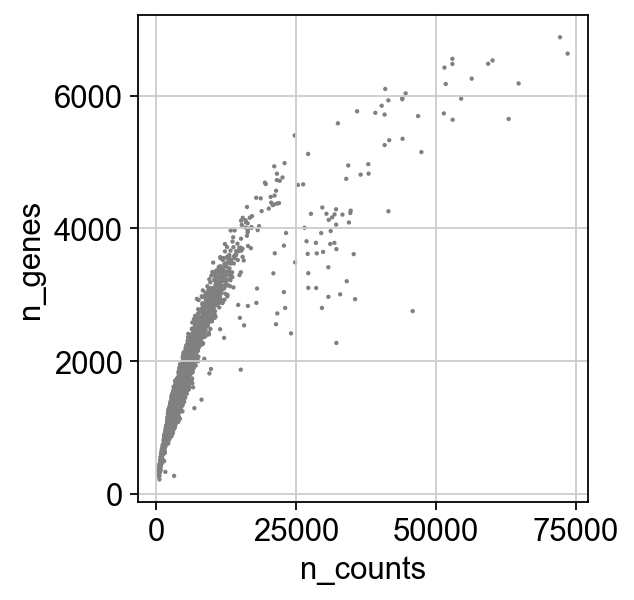

In [10]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [11]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.3, :]

In [12]:
# Data in log scale
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

adata.raw = adata

Trying to set attribute `.obs` of view, making a copy.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


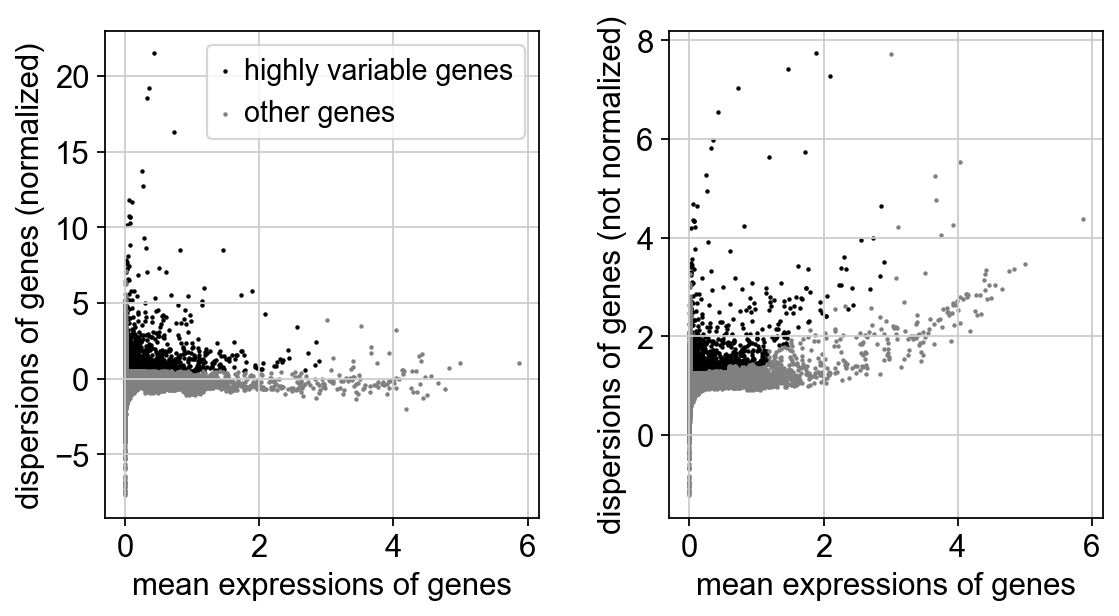

In [13]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [14]:
adata = adata[:, adata.var['highly_variable']]

In [15]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:16.53)


In [16]:
sc.pp.scale(adata, max_value=10)

In [17]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02.51)


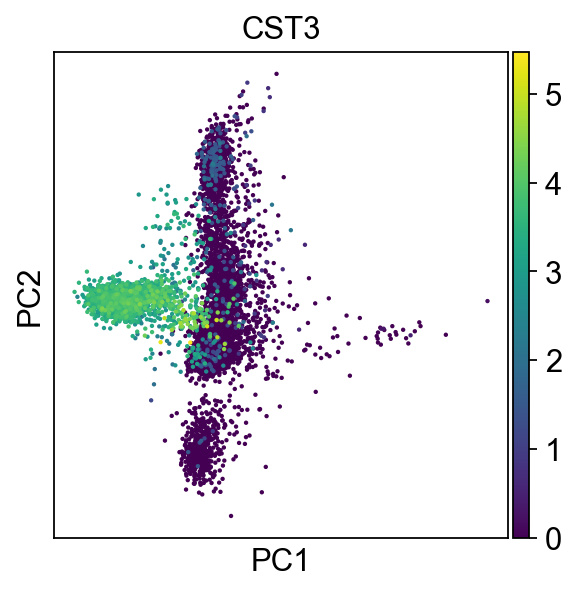

In [18]:
sc.pl.pca(adata, color='CST3')

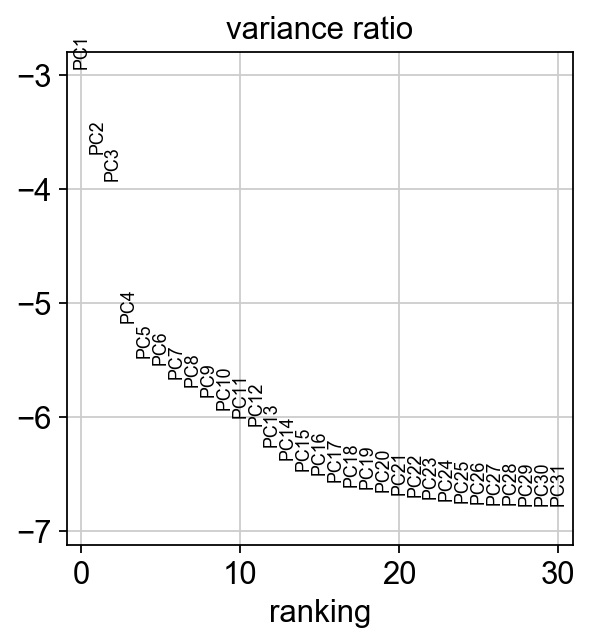

In [19]:
sc.pl.pca_variance_ratio(adata, log=True)

In [20]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40


/Users/molinaro/scAAE/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../scAAE/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/molinaro/scAAE/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../scAAE/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/molinaro/scAAE/lib/python3.7/site-packages/numba/compiler.py:734: NumbaDeprecationWarning: 
Fall-back from the no

    finished (0:00:04.27) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [21]:
sc.tl.umap(adata)

computing UMAP
    using 'X_pca' with n_pcs = 40
    finished (0:00:12.86) --> added
    'X_umap', UMAP coordinates (adata.obsm)


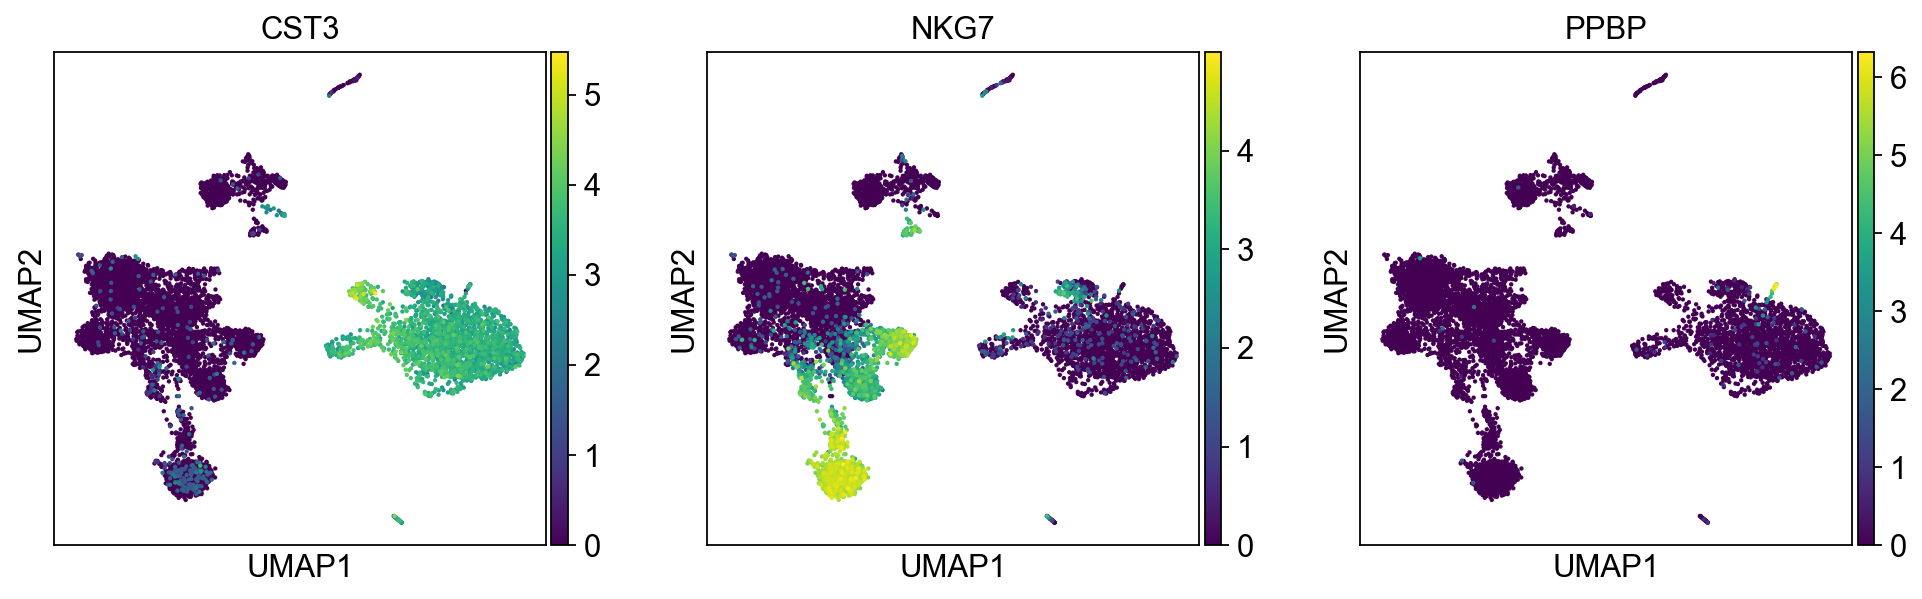

In [22]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

In [23]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.18) --> found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


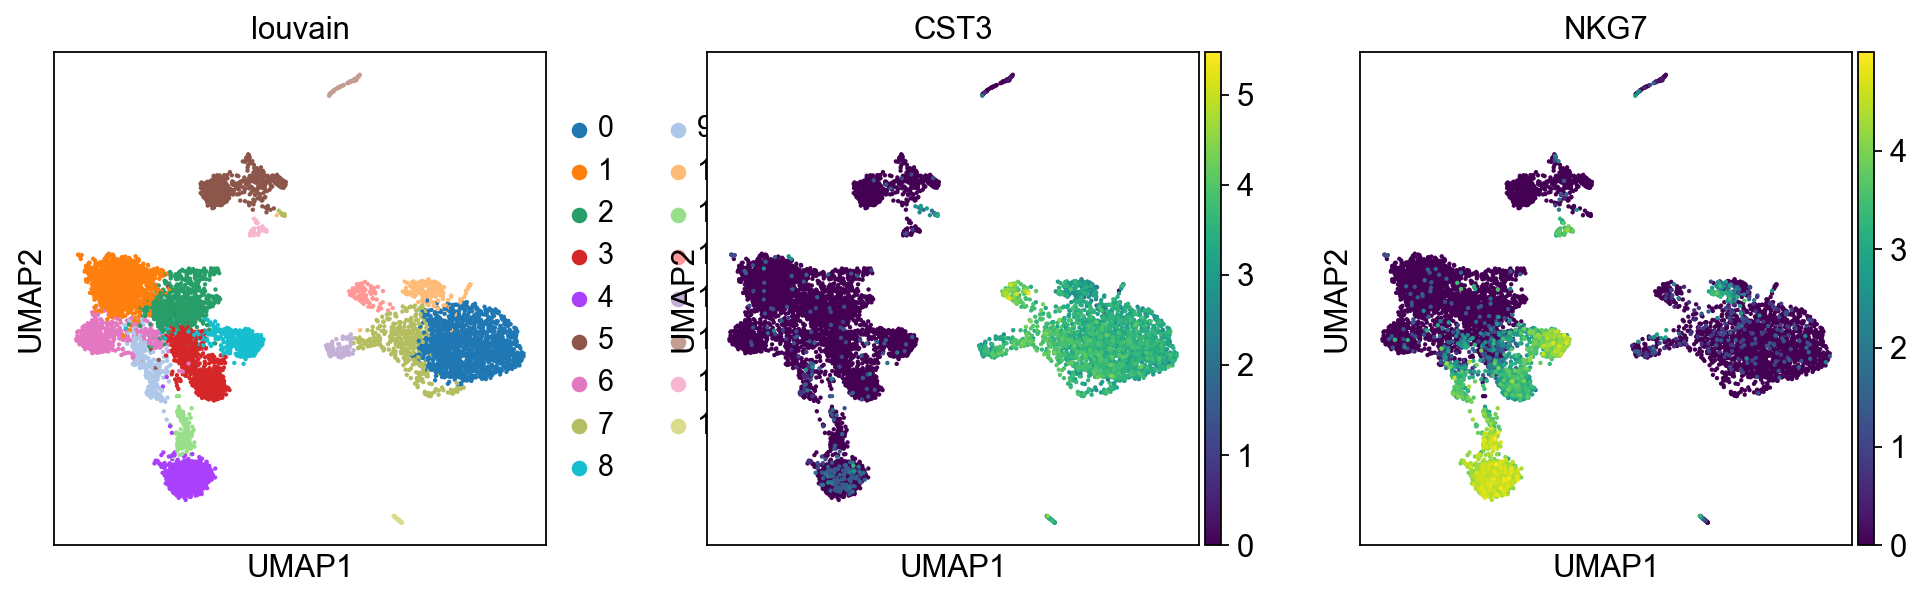

In [24]:
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7'])

ranking genes


/Users/molinaro/scAAE/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/molinaro/scAAE/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/molinaro/scAAE/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


    finished (0:00:10.06) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


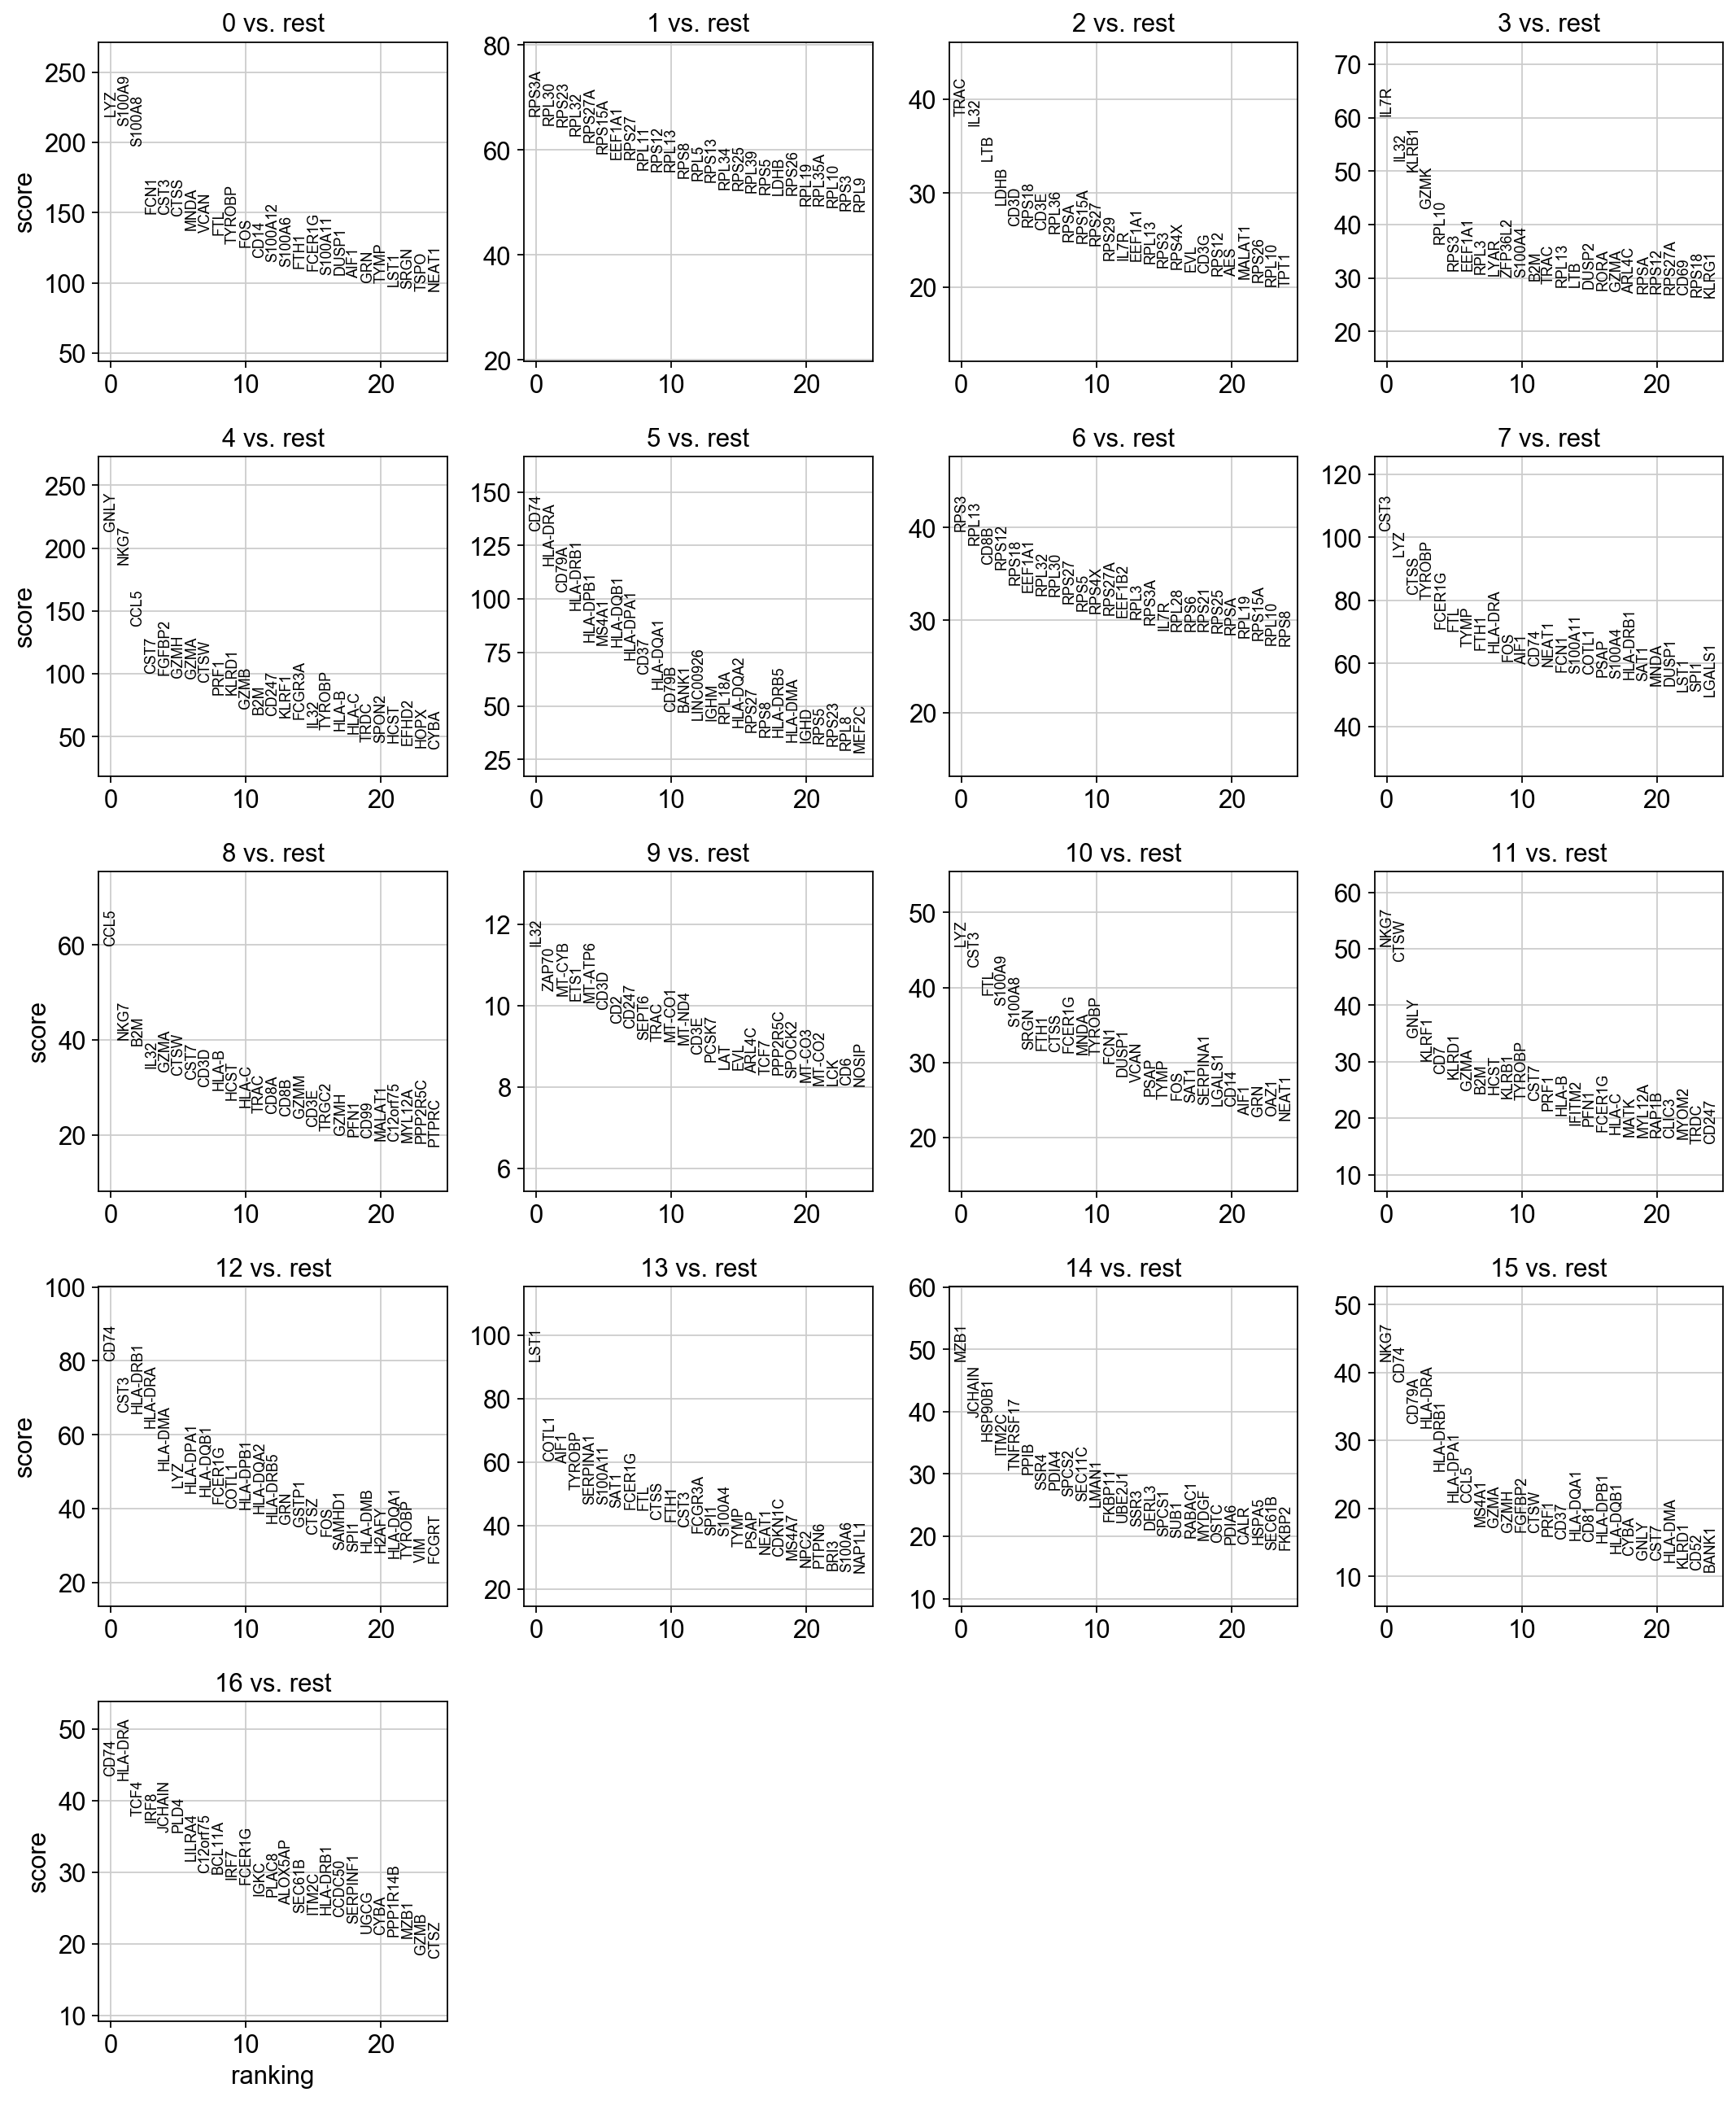

In [25]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [26]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [27]:
#Louvain    Markers       Cell Type
#0          IL7R, CD4     T cells
#1          CD14, LYZ     CD14+ Monocytes
#2          MS4A1         B cells
#3          CD8A, CD8     T cells
#4          GNLY, NKG7    NK cells
#5          FCGR3A, MS4A7 FCGR3A+ Monocytes
#6          FCER1A, CST3  Dendritic Cells
#7          PPBP          Megakaryocytes

new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

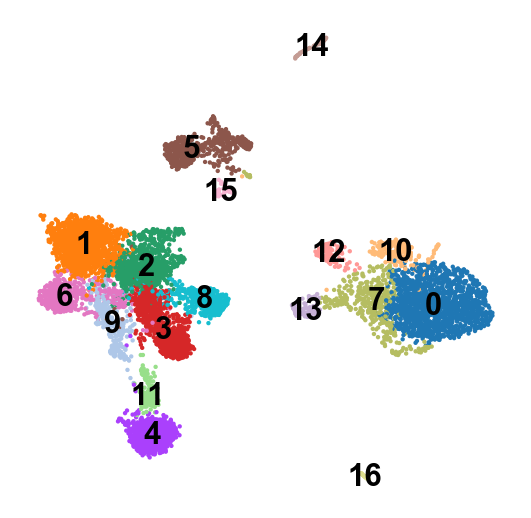

In [28]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False)

In [29]:
adata.obs.shape

(7756, 4)

In [30]:
adata.obs.head()

,n_genes,percent_mito,n_counts,louvain
0,,,,
AAACCCAAGATTGTGA-1,2194,0.084903,6160.0,0
AAACCCACATCGGTTA-1,2093,0.061820,6713.0,0
AAACCCAGTACCGCGT-1,1518,0.078911,3637.0,0
AAACCCAGTATCGAAA-1,737,0.088424,1244.0,4
AAACCCAGTCGTCATA-1,1240,0.059747,2611.0,4


In [31]:
adata.var.shape

(1972, 7)

In [32]:
adata.var.head()

,gene_ids,feature_types,n_cells,highly_variable,means,dispersions,dispersions_norm
HES4,ENSG00000188290,Gene Expression,131,True,0.045170,1.462180,1.151113
ISG15,ENSG00000187608,Gene Expression,2282,True,0.697626,1.660043,1.234033
C1orf159,ENSG00000131591,Gene Expression,223,True,0.070364,1.314917,0.663855
TNFRSF18,ENSG00000186891,Gene Expression,373,True,0.133355,1.470949,1.180127
TNFRSF4,ENSG00000186827,Gene Expression,533,True,0.207609,1.508394,1.304025


In [33]:
adata.var_names

Index(['HES4', 'ISG15', 'C1orf159', 'TNFRSF18', 'TNFRSF4', 'AL645728.1',
       'MIB2', 'MMP23B', 'MORN1', 'TNFRSF14-AS1',
       ...
       'MX1', 'PWP2', 'AP001059.3', 'AP001059.2', 'COL6A2', 'LSS', 'C21orf58',
       'PCNT', 'DIP2A', 'S100B'],
      dtype='object', length=1972)

In [34]:
gene_names = adata.var_names.values

In [35]:
data = adata.X
#data = normalize(data, axis=-1, order=2)
print(np.any(np.isnan(data)))

False


### embedding

In [36]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

In [37]:
genes_encoder = LabelEncoder()
genes_encoded = genes_encoder.fit_transform(gene_names)
print(genes_encoded)

[ 820  942  322 ... 1330  580 1538]


In [38]:
genes_OHE = to_categorical(genes_encoded)

In [39]:
from numpy import argmax

inverted = genes_encoder.inverse_transform([argmax(genes_OHE[0, :])])
print(inverted)

['HES4']


In [40]:
inverted = argmax(genes_OHE[0])
print(inverted)

820


## Variational Autoencoder Model

### Network parameters

In [41]:
original_dim = data.shape[1]

layer_1_dim = 100
layer_2_dim = 50
layer_3_dim = 50
batch_size = 35
latent_dim = 50
epochs = 200

In [42]:
encoder, decoder, vae = build_VAE(original_dim, latent_dim, layer_1_dim, layer_2_dim, layer_3_dim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1972)         0                                            
__________________________________________________________________________________________________
DO (Dropout)                    (None, 1972)         0           X[0][0]                          
__________________________________________________________________________________________________
H1 (Dense)                      (None, 100)          197200      DO[0][0]                         
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H1[0][0]                         
____________________________________________________________________________________________

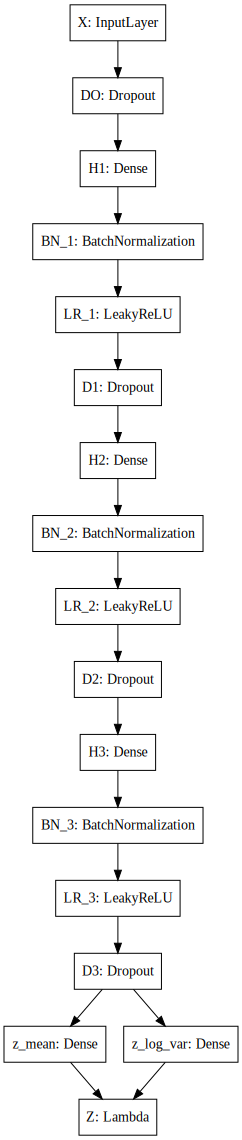

In [43]:
print("\nEncoder Network")
print("===============")
print(encoder.summary())
os.makedirs('../graphs', exist_ok=True)
plot_model(encoder, to_file='../graphs/vae_encoder.png', show_shapes=True)
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))


Decoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 50)                0         
_________________________________________________________________
DO (Dropout)                 (None, 50)                0         
_________________________________________________________________
H1 (Dense)                   (None, 50)                2500      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 50)                200       
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 50)                0         
_________________________________________________________________
D1 (Dropout)                 (None, 50)                0         
_________________________________________________________________
H2 (Dense)                   (None, 50)                2500

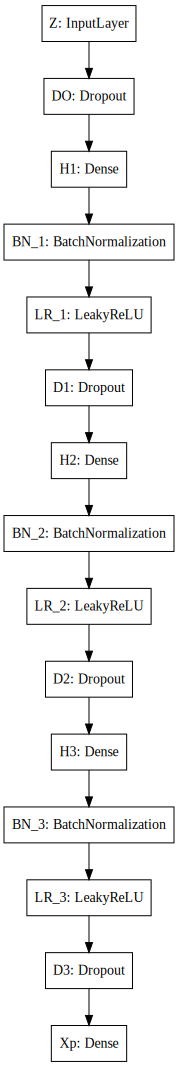

In [44]:
print("\nDecoder Network")
print("===============")
print(decoder.summary())
plot_model(decoder, to_file='../graphs/vae_decoder.png', show_shapes=True)
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))


Autoencoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 1972)              0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  210600    
_________________________________________________________________
decoder (Model)              (None, 1972)              209972    
Total params: 420,572
Trainable params: 419,772
Non-trainable params: 800
_________________________________________________________________


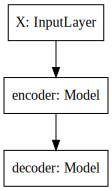

In [45]:
print("\nAutoencoder Network")
print("===================")
vae.summary()
plot_model(decoder, to_file='../graphs/vae_autoencoder.png', show_shapes=True)
SVG(model_to_dot(vae).create(prog='dot', format='svg'))

### Model training

In [46]:
vae_history = train_VAE(vae, data, batch_size, epochs)

# save model
os.makedirs('../models', exist_ok=True)
vae.save_weights('../models/vae_mnist.h5')

Instructions for updating:
Use tf.cast instead.
Train on 6204 samples, validate on 1552 samples
Epoch 1/200
6204/6204 [==============================] - 5s 736us/step - loss: 2323.1060 - val_loss: 2261.0465
Epoch 2/200
6204/6204 [==============================] - 2s 374us/step - loss: 2108.0507 - val_loss: 2123.4381
Epoch 3/200
6204/6204 [==============================] - 2s 316us/step - loss: 2039.1732 - val_loss: 2050.0890
Epoch 4/200
6204/6204 [==============================] - 2s 301us/step - loss: 2002.0183 - val_loss: 2017.7181
Epoch 5/200
6204/6204 [==============================] - 2s 302us/step - loss: 1982.3568 - val_loss: 2004.4535
Epoch 6/200
6204/6204 [==============================] - 2s 310us/step - loss: 1970.6974 - val_loss: 1991.0389
Epoch 7/200
6204/6204 [==============================] - 2s 302us/step - loss: 1959.4848 - val_loss: 1979.8820
Epoch 8/200
6204/6204 [==============================] - 2s 317us/step - loss: 1950.3316 - val_loss: 1973.2419
Epoch 9/200
6204

6204/6204 [==============================] - 2s 324us/step - loss: 1872.8708 - val_loss: 1897.1133
Epoch 72/200
6204/6204 [==============================] - 2s 313us/step - loss: 1872.0683 - val_loss: 1896.5793
Epoch 73/200
6204/6204 [==============================] - 2s 319us/step - loss: 1872.1570 - val_loss: 1896.1433
Epoch 74/200
6204/6204 [==============================] - 2s 319us/step - loss: 1871.0626 - val_loss: 1895.9959
Epoch 75/200
6204/6204 [==============================] - 2s 308us/step - loss: 1870.8228 - val_loss: 1895.8752
Epoch 76/200
6204/6204 [==============================] - 2s 313us/step - loss: 1870.5181 - val_loss: 1895.5260
Epoch 77/200
6204/6204 [==============================] - 2s 317us/step - loss: 1869.8272 - val_loss: 1894.8276
Epoch 78/200
6204/6204 [==============================] - 2s 310us/step - loss: 1869.8855 - val_loss: 1894.5129
Epoch 79/200
6204/6204 [==============================] - 2s 305us/step - loss: 1869.2670 - val_loss: 1894.4040
Epoch

Epoch 144/200
6204/6204 [==============================] - 2s 290us/step - loss: 1859.0197 - val_loss: 1885.4576
Epoch 145/200
6204/6204 [==============================] - 2s 321us/step - loss: 1859.1767 - val_loss: 1885.4880
Epoch 146/200
6204/6204 [==============================] - 2s 303us/step - loss: 1858.8555 - val_loss: 1885.5722
Epoch 147/200
6204/6204 [==============================] - 2s 301us/step - loss: 1859.4362 - val_loss: 1885.5899
Epoch 148/200
6204/6204 [==============================] - 2s 301us/step - loss: 1859.3144 - val_loss: 1885.1890
Epoch 149/200
6204/6204 [==============================] - 2s 310us/step - loss: 1858.9837 - val_loss: 1885.5523
Epoch 150/200
6204/6204 [==============================] - 2s 309us/step - loss: 1858.7653 - val_loss: 1885.2050
Epoch 151/200
6204/6204 [==============================] - 2s 301us/step - loss: 1858.9735 - val_loss: 1885.3999
Epoch 152/200
6204/6204 [==============================] - 2s 304us/step - loss: 1858.2587 - val

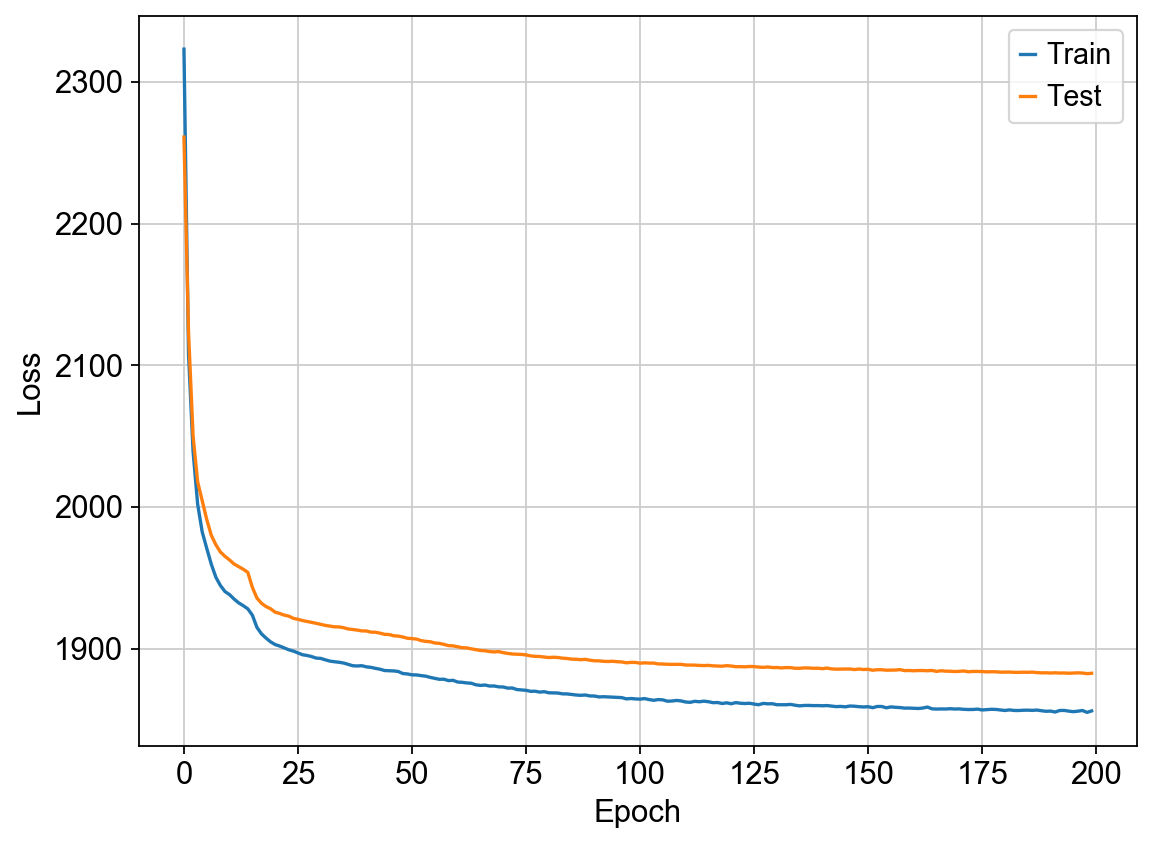

In [50]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(vae_history.history['loss'])
plt.plot(vae_history.history['val_loss'])
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([570,700])
#plt.loglog()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

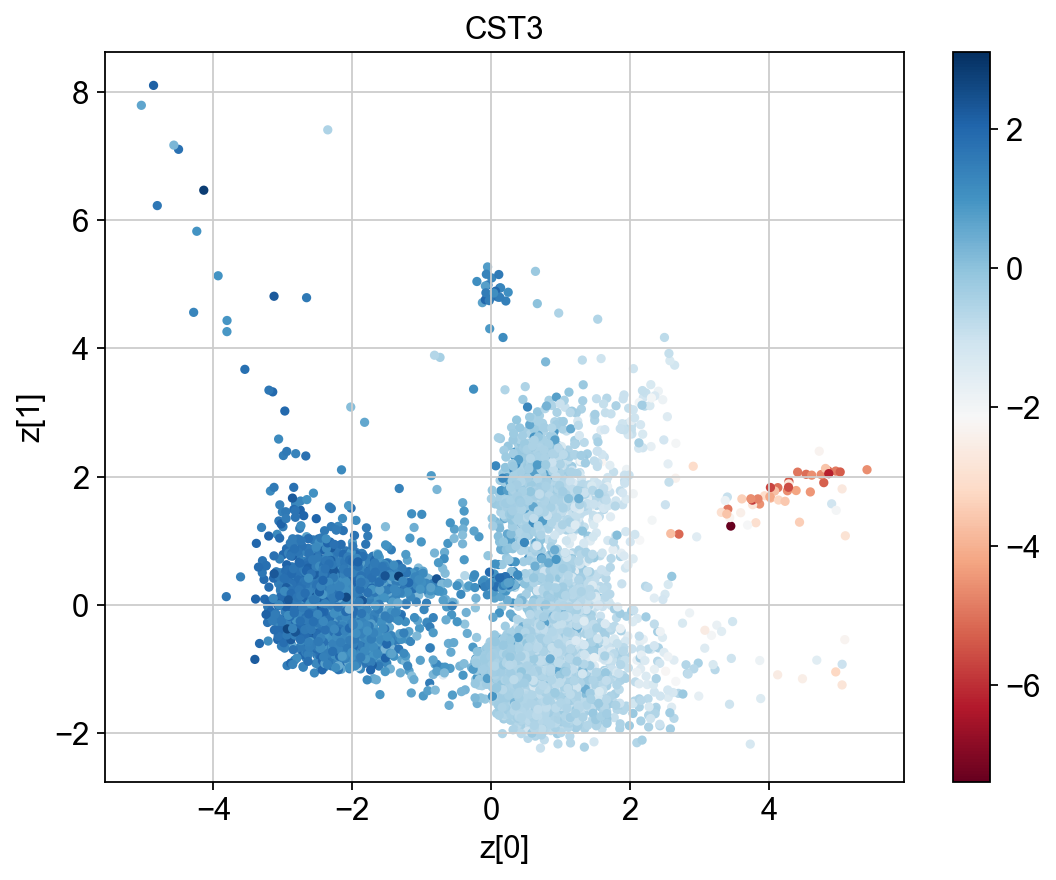

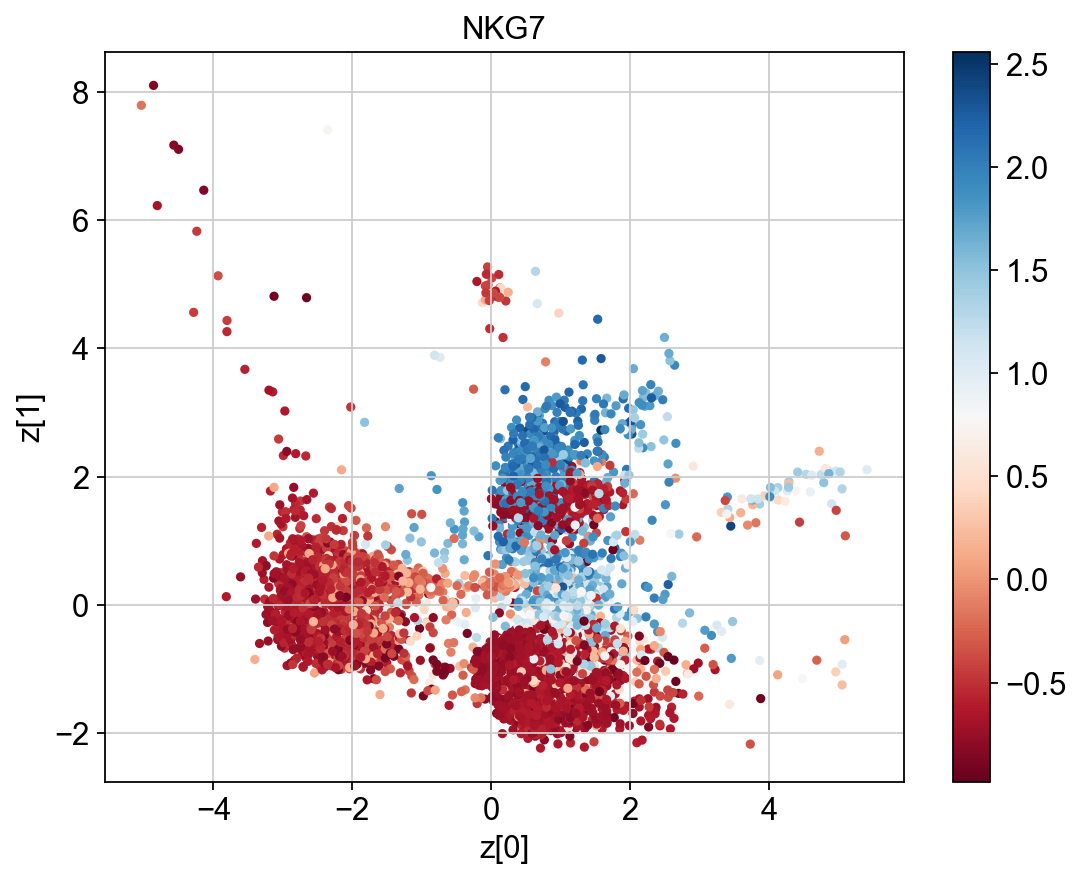

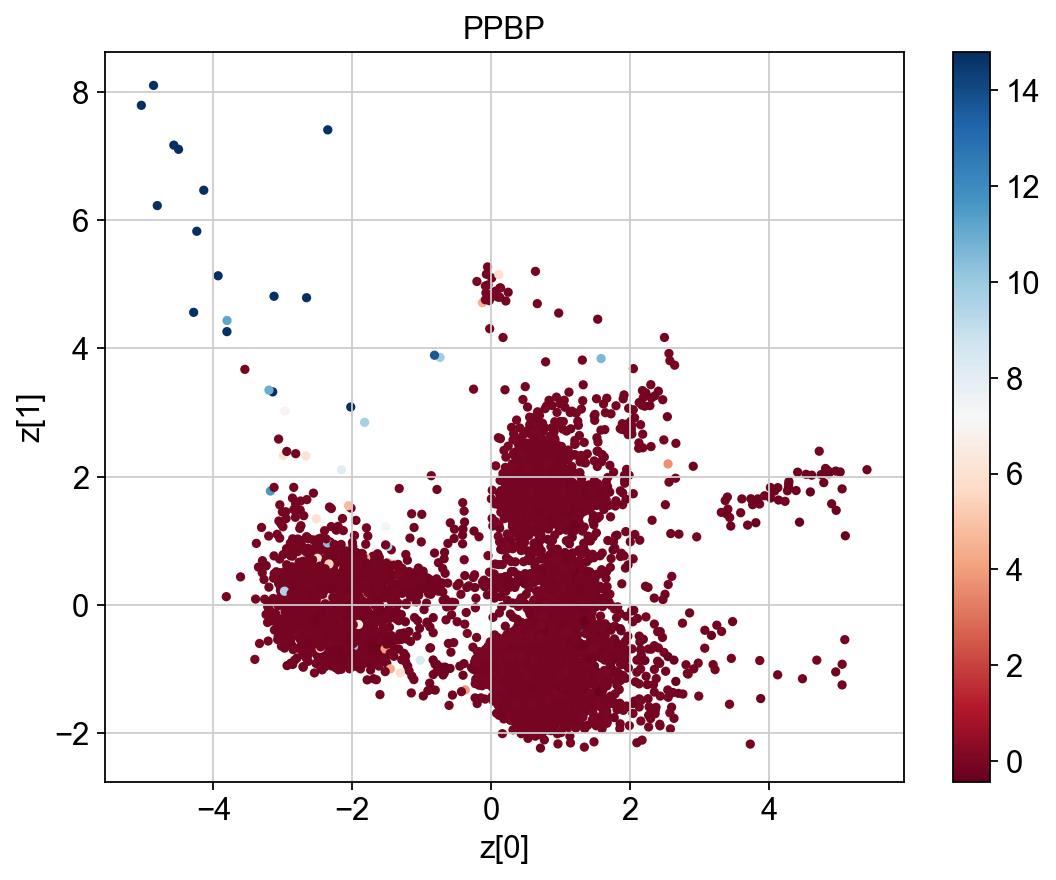

In [51]:
models = (encoder, decoder)
gene_list = ['CST3', 'NKG7', 'PPBP']
plot_results_pca(models, data, gene_list, gene_names, latent_dim)

/Users/molinaro/scAAE/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../scAAE/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


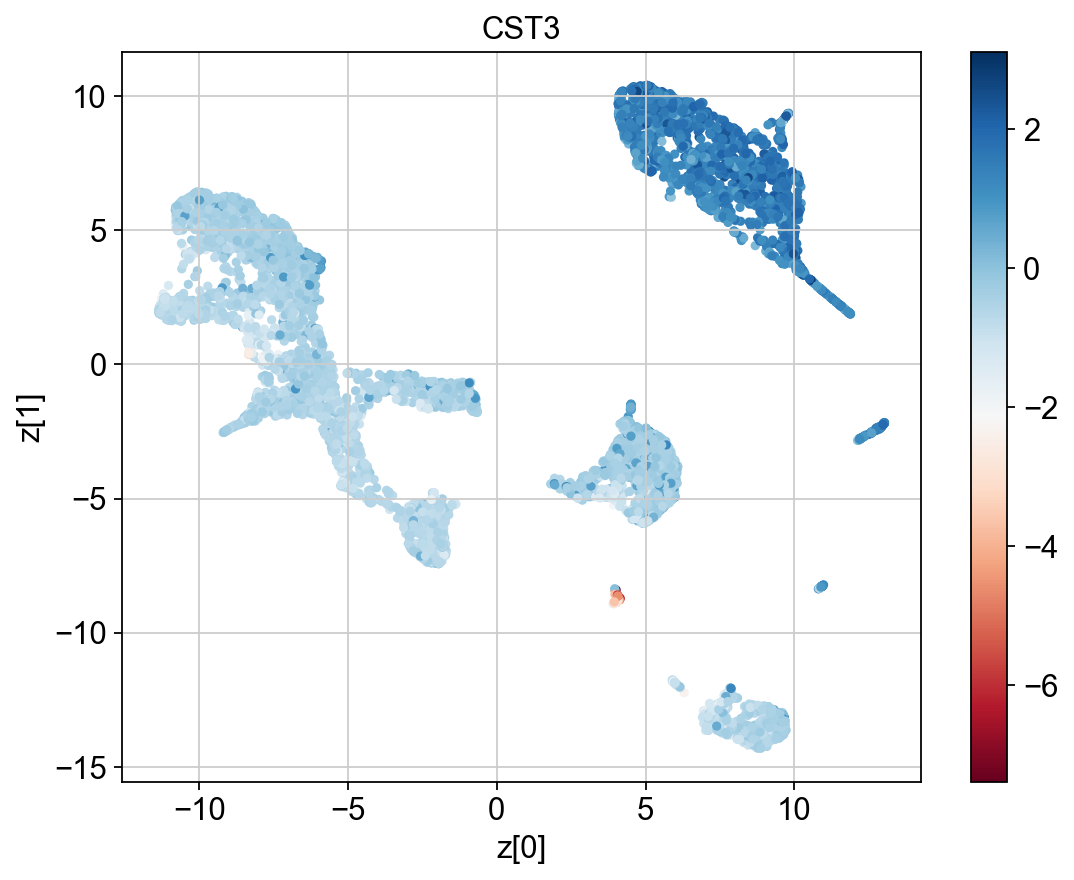

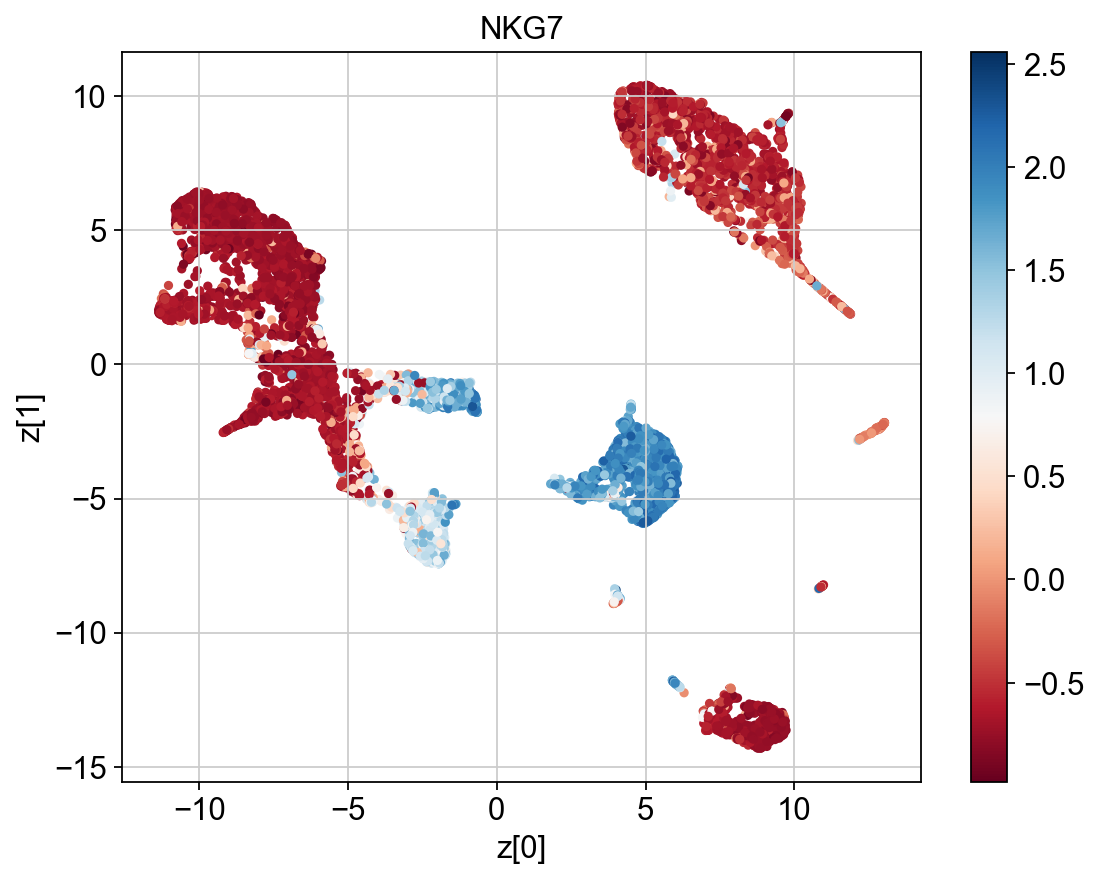

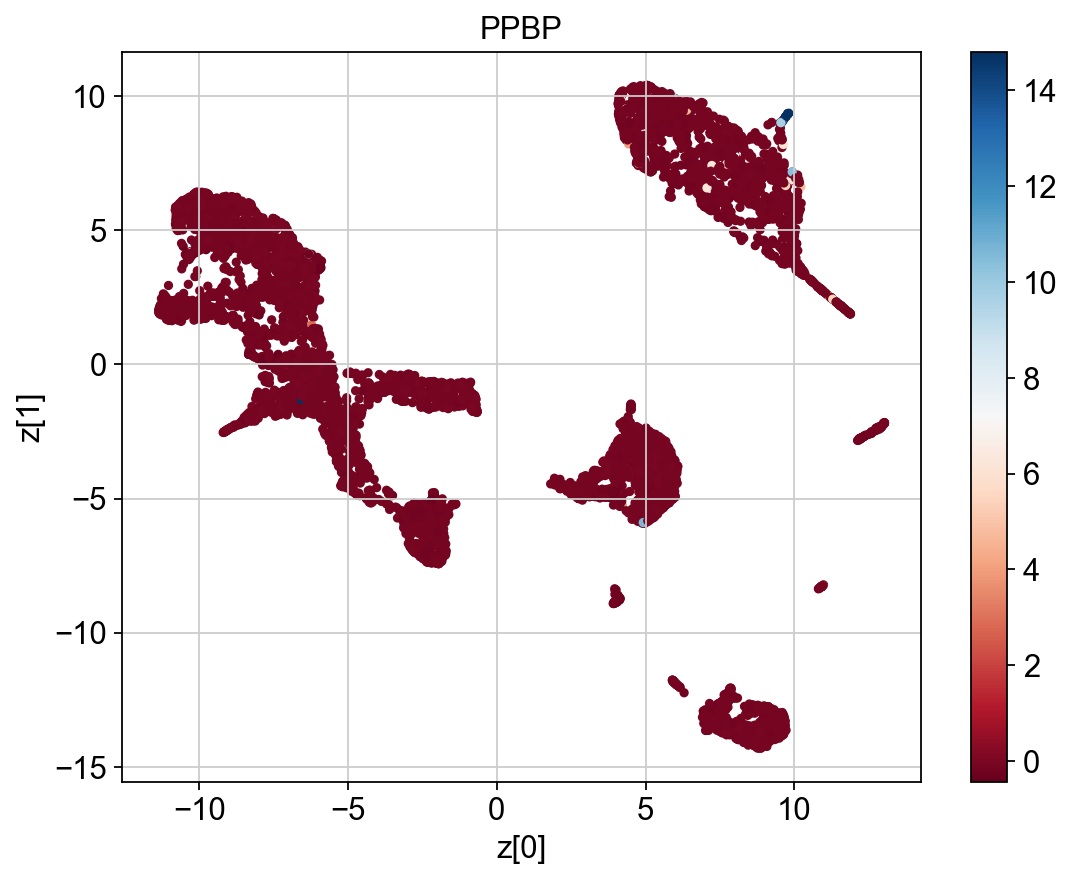

In [52]:
models = (encoder, decoder)
gene_list = ['CST3', 'NKG7', 'PPBP']
plot_results_umap(models, data, gene_list, gene_names, latent_dim)